### Classify Ship images using CNN

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

C:\Amrendra\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.chdir("D:\My Personal Documents\Learnings\Data Science\Hackathan - Game of Deep Learning v1\\train")

In [3]:
train = pd.read_csv('train.csv')

In [45]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('images/'+train['image'][i], target_size=(28,28,3), grayscale=False)
    img = image.img_to_array(img)
    #img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████████████████████████████████████████████████████████████████████| 12504/12504 [00:10<00:00, 1172.95it/s]


In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 197
WIDTH = 197
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

C:\Amrendra\Anaconda\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [4]:
from keras.preprocessing.image import ImageDataGenerator
os.chdir("D:\My Personal Documents\Learnings\Data Science\Hackathan - Game of Deep Learning v1")
TRAIN_DIR = "ImgDir"
HEIGHT = 197
WIDTH = 197
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

Found 15 images belonging to 3 classes.


In [5]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

        # New softmax layer

    predictions = Dense(num_classes, activation='softmax')(x) 
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["Cargo", "Military", "Cruise"]

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [10]:
from keras.optimizers import SGD, Adam

NUM_EPOCHS = 1
BATCH_SIZE = 8
num_train_images = 100
adam = Adam(lr=0.00001)

finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="checkpoints"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)


plot_training(history)

# Plot the training and validation loss + accuracy

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
   # plt.title('Training and validation loss')
    plt.show()

Epoch 1/1
12/12 [==============================] - ETA: 2:51 - loss: 1.0985 - acc: 0.625 - ETA: 1:50 - loss: 1.3575 - acc: 0.526 - ETA: 1:24 - loss: 1.6482 - acc: 0.494 - ETA: 1:10 - loss: 1.3860 - acc: 0.589 - ETA: 58s - loss: 1.2713 - acc: 0.585 - ETA: 49s - loss: 1.4474 - acc: 0.57 - ETA: 41s - loss: 1.4899 - acc: 0.56 - ETA: 32s - loss: 1.3575 - acc: 0.59 - ETA: 23s - loss: 1.2694 - acc: 0.61 - ETA: 15s - loss: 1.2904 - acc: 0.61 - ETA: 7s - loss: 1.4439 - acc: 0.5958 - 93s 8s/step - loss: 1.4298 - acc: 0.5984

Epoch 00001: saving model to checkpoints


NameError: name 'plot_training' is not defined

In [46]:
finetune_model.predict()

(12504, 28, 28, 3)

In [47]:
y=train['category'].values
#y = to_categorical(y)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [49]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10003, 28, 28, 3)
(10003,)
(2501, 28, 28, 3)
(2501,)


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if __name__ == '__main__':


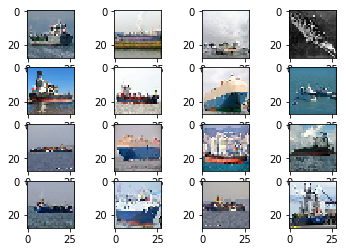

In [13]:
from matplotlib import pyplot
from scipy.misc import toimage
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
show_imgs(x_test[:16])

In [50]:
x_train=x_train/255
x_test = x_test/255


In [51]:
n_class=6
y_train = keras.utils.to_categorical(y_train,n_class)
y_test = keras.utils.to_categorical(y_test,n_class)

In [52]:
n_conv = 64
k_conv = (3,3)

In [ ]:
y_train.shape

In [53]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))



model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='softmax'))

In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model.fit(x_train,y_train,epochs=1,verbose=1, validation_data=(x_test,y_test))

Train on 10003 samples, validate on 2501 samples
Epoch 1/1
 6496/10003 [==================>...........] - ETA: 9:17 - loss: 2.5239 - acc: 0.156 - ETA: 7:53 - loss: 2.3550 - acc: 0.281 - ETA: 7:10 - loss: 2.3896 - acc: 0.250 - ETA: 6:45 - loss: 2.3066 - acc: 0.273 - ETA: 6:24 - loss: 2.2086 - acc: 0.281 - ETA: 6:18 - loss: 2.1407 - acc: 0.286 - ETA: 6:14 - loss: 2.0781 - acc: 0.294 - ETA: 6:08 - loss: 2.1340 - acc: 0.293 - ETA: 6:06 - loss: 2.0797 - acc: 0.291 - ETA: 5:58 - loss: 2.0373 - acc: 0.293 - ETA: 5:49 - loss: 2.0043 - acc: 0.301 - ETA: 5:44 - loss: 1.9923 - acc: 0.309 - ETA: 5:43 - loss: 2.0047 - acc: 0.307 - ETA: 5:41 - loss: 1.9635 - acc: 0.321 - ETA: 5:38 - loss: 1.9560 - acc: 0.318 - ETA: 5:39 - loss: 1.9548 - acc: 0.318 - ETA: 5:34 - loss: 1.9197 - acc: 0.321 - ETA: 5:30 - loss: 1.9184 - acc: 0.314 - ETA: 5:29 - loss: 1.8955 - acc: 0.324 - ETA: 5:26 - loss: 1.8917 - acc: 0.323 - ETA: 5:25 - loss: 1.8965 - acc: 0.321 - ETA: 5:24 - loss: 1.8811 - acc: 0.323 - ETA: 5:21 - lo

In [19]:
os.chdir("D:\My Personal Documents\Learnings\Data Science\Hackathan - Game of Deep Learning\\train")
test = pd.read_csv('test_ApKoW4T.csv')

In [20]:
test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('images/'+test['image'][i], target_size=(197,197,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test = np.array(test_image)

100%|█████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:10<00:00, 252.03it/s]


In [21]:
prediction = finetune_model.predict(test)

In [22]:
pd.DataFrame(prediction).to_csv('test_pred.csv')

In [ ]:
model.save('trained_epoch_5.h5')

In [ ]:
filepath='trained_epoch_5.h5'

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
new_model = load_model('trained_epoch_5.h5')

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
callback_list = [checkpoint]

In [ ]:
new_model.fit(x_train,y_train, epochs=20, validation_data=(x_test,y_test),callbacks = callback_list)

In [ ]:
new_model.save('trained_epoch_25.h5')

In [ ]:
prediction = new_model.predict_classes(test)

In [ ]:
pd.DataFrame(prediction).to_csv('test_pred.csv')

In [ ]:
filepath='trained_epoch_25.h5'

In [ ]:
new_model1 = load_model('trained_epoch_25.h5')

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
callback_list = [checkpoint]

In [ ]:
new_model1.fit(x_train,y_train, epochs=20, validation_data=(x_test,y_test),callbacks = callback_list)

In [ ]:
prediction=new_model1.predict_classes(test)

In [ ]:
pd.DataFrame(prediction).to_csv('test_pred.csv')